# Image Analysis with Python

## Importing dependencies

We use `math`, `scipy`, and `numpy` in order to do our computations. For visualizations, we use `matplotlib`. We also use the `time` package to evaluate performance. To make these available we must `import` them:

In [5]:
import scipy
import scipy.signal
import scipy.ndimage
import numpy as np
from matplotlib import pyplot as plt
import math, time
from mpl_toolkits.axes_grid1 import make_axes_locatable


To get plots to appear inline in this notebook setting, we must issue the following directive:

In [6]:
%matplotlib inline  

## Plotting and Timing

We will use a couple neat tricks to make the code below look cleaner:

* A Plotting function
* A class to help time routines

In [7]:
def Plot(list_of_things_to_plot):
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    for i,x in enumerate(list_of_things_to_plot):
        plt.subplot(1,len(list_of_things_to_plot),i+1,aspect='equal'); plt.pcolor(x); plt.colorbar(); plt.gca().invert_yaxis()
        
class Timer(object):
    def __init__(self, name=None):
        self.name = name
    def __enter__(self):
        self.tstart = time.time()
    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name)
        print('Elapsed: %s seconds' % (time.time() - self.tstart))

## Loading a data frame

We can read the data directly from a `.bmp` file:

In [8]:
bmp = scipy.misc.imread('/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast/g21flow/bmps_cropped/00046.bmp')

What this has created is a 275x275 numpy array populated with 8-bit integers:

In [9]:
type(bmp), bmp.shape, bmp.dtype

(numpy.ndarray, (421, 421), dtype('uint8'))

In order to do numerics, we will prefer to have it as floating point data:

In [10]:
u = bmp.astype(float)
type(u), u.shape, u.dtype

(numpy.ndarray, (421, 421), dtype('float64'))

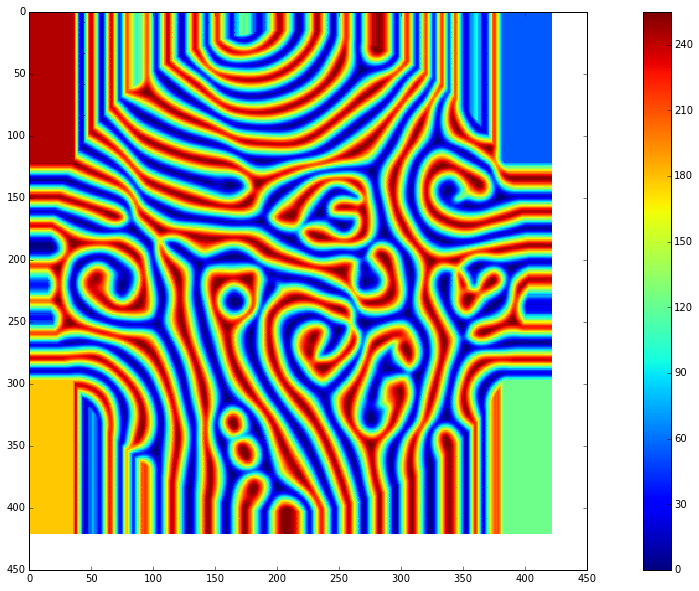

In [40]:
Plot([u])

# Computation of Derivatives

We consider the following approaches to computing derivatives:

* Differencing schemes
  * First order (`np.diff`)
  * Second order (`np.gradient`)
* Fourier differentiation
 

## First order difference

This technique subtracts consecutive elements in order to produce approximation of the derivatives $u_x$ and $u_y$.
There is an issue with this technique whereby the size of the output actually differs from the size of the input. The reason is that given $n$ consecutive data points, there are only $n-1$ differences that can be obtained. This is implemented as `np.diff`:

((421, 421), (420, 421), (421, 420))

/Users/birdbrain/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


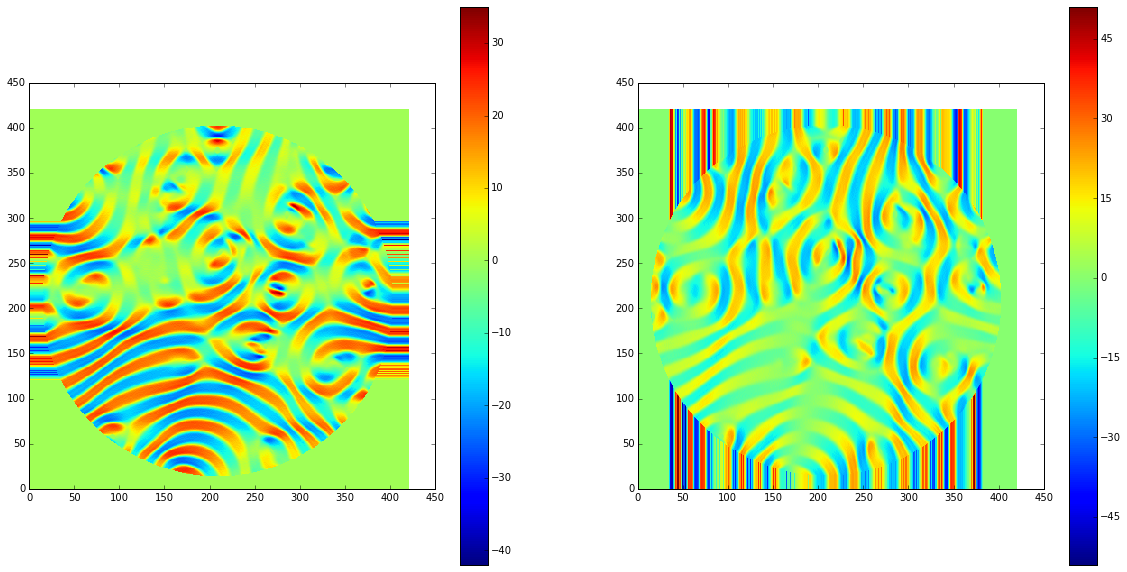

In [8]:
ux = np.diff(u, axis=0)
uy = np.diff(u, axis=1)
Plot([ux, uy])
u.shape, ux.shape, uy.shape

## Second order difference scheme

A more accurate (higher order) approach which fixes the issue of changing the size of the array is to compute the average of the left-handed difference and the right-handed difference. At the left or right edges of the image where only the right-handed or left-handed difference (respectively) exists, the first-order difference is used. This is implemented as `np.gradient`.

((421, 421), (421, 421), (421, 421))

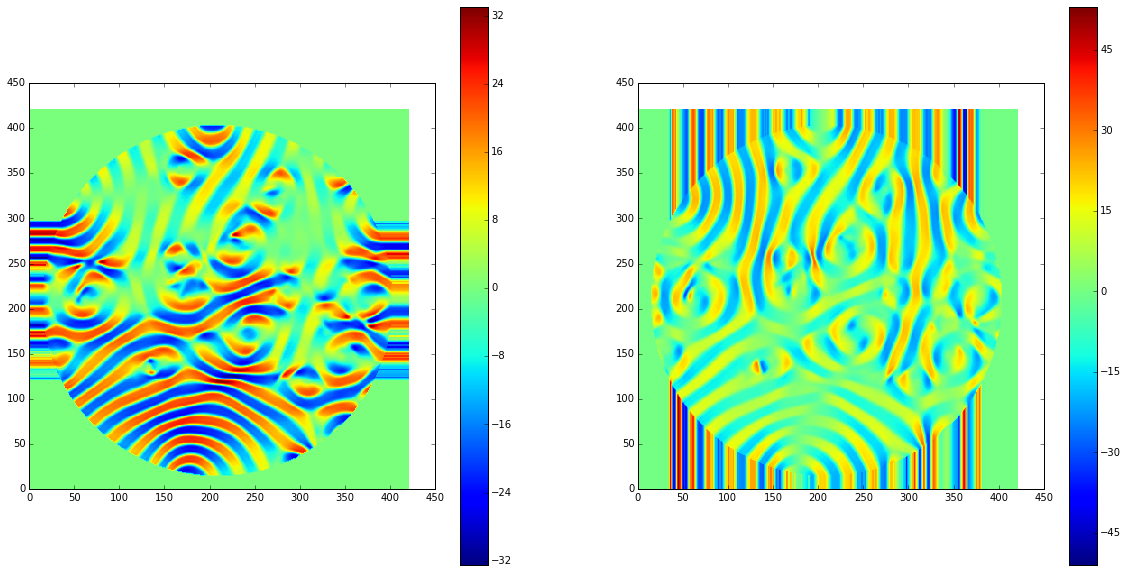

In [18]:
[ux, uy] = np.gradient(u)
Plot([ux, uy])
u.shape, ux.shape, uy.shape

## Fourier Spectral Differentiation

The Fourier transform of a derivative of a function is the Fourier transform of the function multiplied by a function proportional to the frequency. This gives rise to a numerical technique. See <http://math.mit.edu/~stevenj/fft-deriv.pdf> for information on implementation.

In [7]:
def fourier_diff(u, order=1):
    [N, M] = u.shape
    [kx, ky] = np.mgrid[0:N,0:M]
    kx = kx - float(N) * ( kx > float(N)/2.0 )
    ky = ky - float(M) * ( ky > float(M)/2.0 )    
    if order % 2 == 1 and N % 2 == 0: kx[N//2,:] = 0.0
    if order % 2 == 1 and M % 2 == 0: ky[:,M//2] = 0.0
    kx = (kx * 2.0 * math.pi * 1j / float(N)) ** order
    ky = (ky * 2.0 * math.pi * 1j / float(M)) ** order
    u_fft = np.fft.fft2(u)
    ux_fft = u_fft * kx
    uy_fft = u_fft * ky
    ux = np.real(np.fft.ifft2(ux_fft))
    uy = np.real(np.fft.ifft2(uy_fft))
    return [ux, uy]

((421, 421), (421, 421), (421, 421))

/Users/birdbrain/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


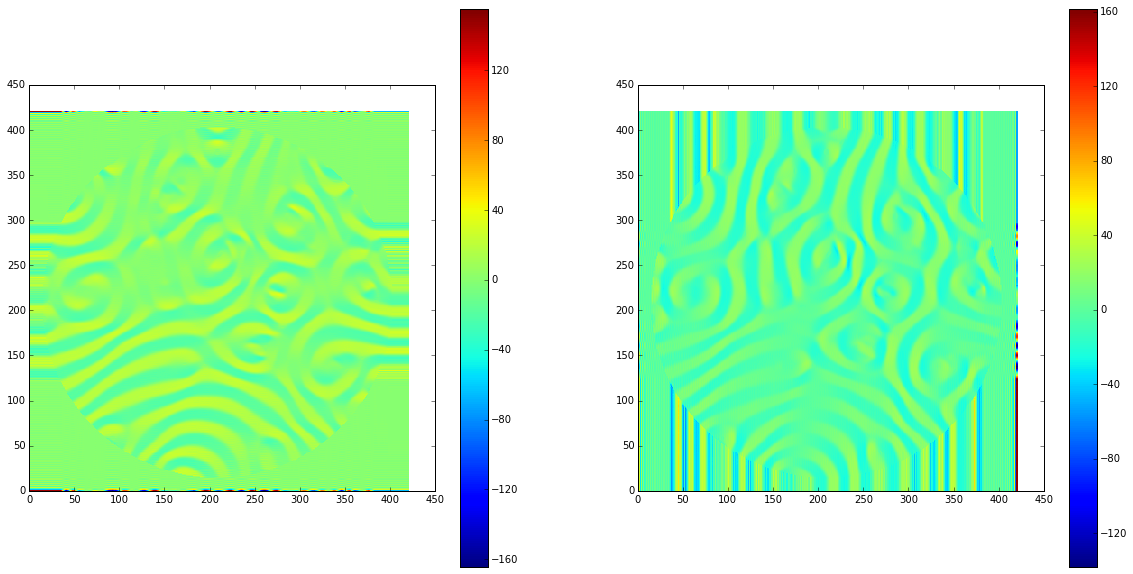

In [10]:
[ux, uy] = fourier_diff(u)
Plot([ux,uy])
ux.shape, uy.shape, u.shape

The above plots look much different from the plot of the gradients achieved by the difference scheme. To investigate this discrepancy, we plot the difference of derivatives computed via both approaches:

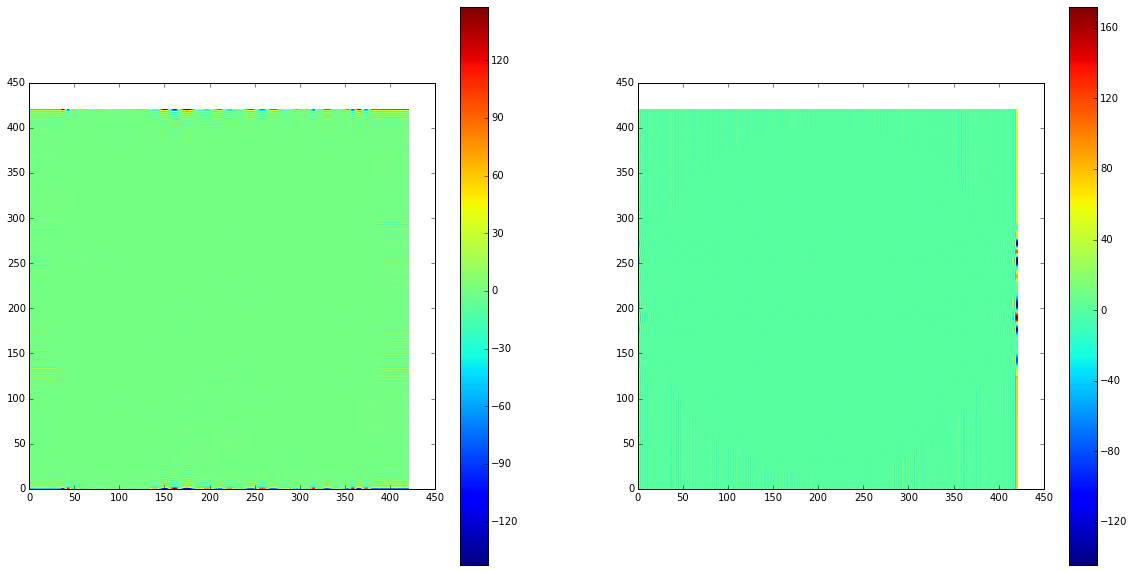

In [21]:
[ux, uy] = np.gradient(u)
[fux, fuy] = fourier_diff(u)
Plot([ux-fux, uy-fuy])

It is clear that the largest differences occur near the fringes of the image. The reason for these fringe effects is the Gibbs phenomenon (https://en.wikipedia.org/wiki/Gibbs_phenomenon) -- the Fourier treatment considers the image as if it were periodicially tiled, so the difference between the left and right edges creates a discontinuity which results in artifacts at the edges.

# The Analysis of Bazen and Gerez

In 

> Bazen, Asker M., and Sabih H. Gerez. "Systematic methods for the computation of the directional fields and singular points of fingerprints." IEEE transactions on pattern analysis and machine intelligence 24.7 (2002): 905-919.

algorithms are given to compute an _direction field_ and locate _singular points_. 

The algorithms of Bazen and Gerez are based on:
1. Computing the "square gradient" (in the sense of squaring a complex number, which doubles its angle and squares its magnitude)
2. Computing the average square gradient using a convolutional filter
3. Recovering the direction field from the average square gradient via 1/2 arctangent (Bazen and Garez also rotate 90 degrees but we do not; accordingly, we call ours an _orientation field_ rather than a direction field)
4. Computing the numerical curl of the orientation field (after fixing discontinuities due to the mod $2 \pi$ nature of the values)

We implement them as follows. Explanations of how the algorithms work will follow.

In [11]:
def OrientationField(du, radius=5):
    """
    Computes orientation field (result everywhere between -pi/2 and pi/2)
    given vector field
    """
    [ux, uy] = du
    Y = scipy.ndimage.filters.gaussian_filter(2.0*ux*uy, sigma=radius)
    X = scipy.ndimage.filters.gaussian_filter(ux**2.0 - uy**2.0, sigma=radius)
    return .5 * np.arctan2(Y, X)

def SingularPoints(DF):
    JX = np.diff(DF, axis=0)
    JY = np.diff(DF, axis=1)
    JX += math.pi * (JX < -math.pi/2.0 ) - math.pi * (JX > math.pi/2.0)
    JY += math.pi * (JY < -math.pi/2.0 ) - math.pi * (JY > math.pi/2.0)
    return np.rint((np.diff(JY, axis=0) - np.diff(JX, axis=1))/math.pi)


/Users/birdbrain/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


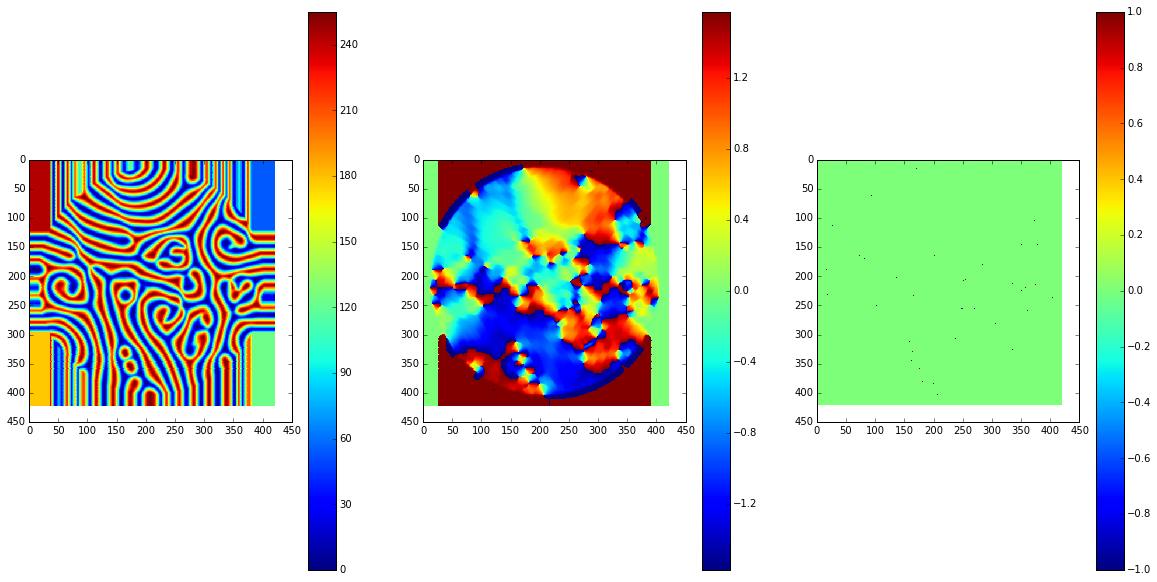

In [12]:

du = np.gradient(u)
OF = OrientationField(du, radius=2)
SP = SingularPoints(OF)

Plot([u, OF, SP])

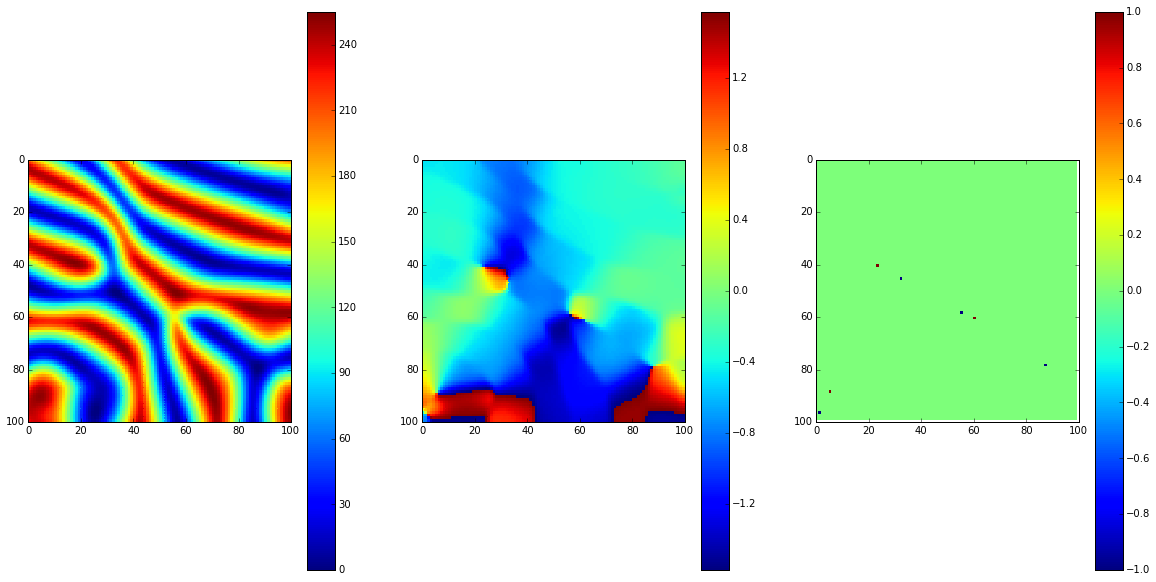

In [13]:
tmp = u[125:225, 50:150]

du = np.gradient(tmp)
OF = OrientationField(du, radius=2)
SP = SingularPoints(OF)

Plot([tmp, OF, SP])

<matplotlib.colorbar.Colorbar instance at 0x11a32d128>

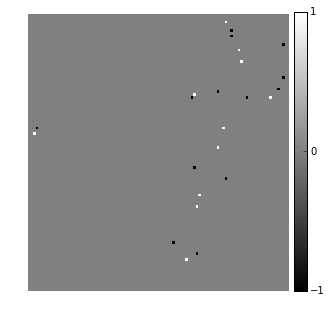

In [30]:
tmp = u[300:400, 100:200]

du = np.gradient(tmp)
OF = OrientationField(du, radius=0.5)
SP = SingularPoints(OF)

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.figure()
ax = plt.gca()
plt.set_cmap('gray')
plt.gca().set_axis_off()
im = ax.pcolor(SP)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks=[-1, 0, 1])

## Orientation Field

An orientation field is an assignment of a vector modulo sign and magnitude at each point in space. They can be represented as scalar fields with values between $-\pi/2$ and $\pi/2$, where the value indicates the angle of a representative vector of the orientation with a positive $x$-coordinate.

We want to compute an orientation field corresponding to a gradient.

Naively we might attempt to do so as follows:

In [9]:
def NaiveOrientationField(du):
    """
    Computes direction field (result everywhere between -pi/2 and pi/2)
    given vector field du
    """
    return np.arctan2(du[1], du[0])

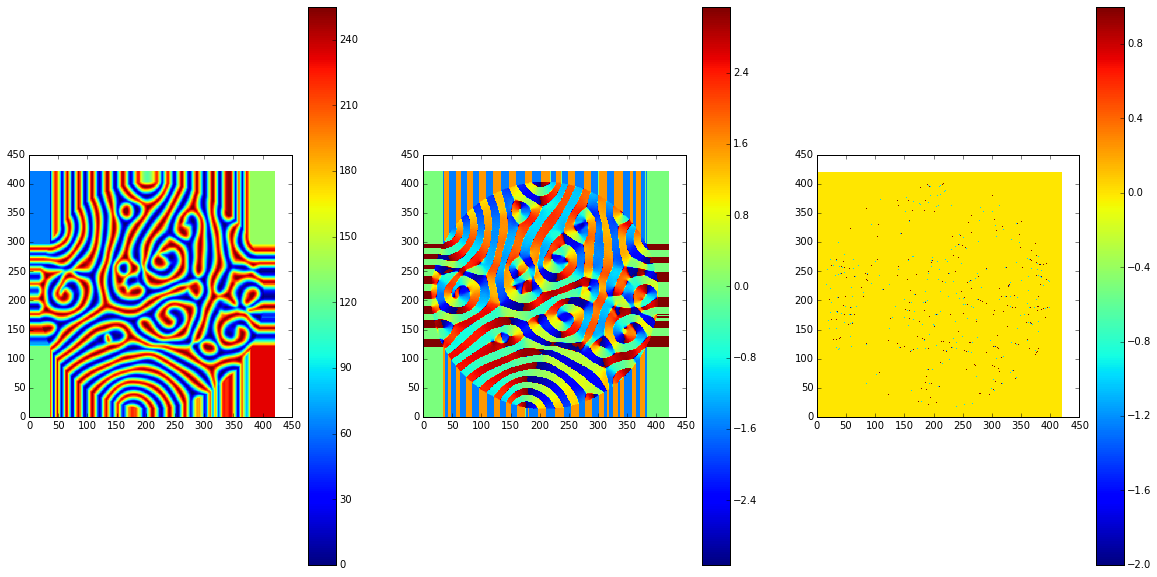

In [24]:
du = np.gradient(u)
OF_naive = NaiveOrientationField(du)
SP_naive = SingularPoints(OF_naive)
Plot([u, OF_naive, SP_naive])

The singular point computation makes it clear that there are contour-shaped numerical artifacts which arise with this approach. The difficulty arises due to an effect at ridges. 

An approach to reducing noise is to apply an averaging operation. By averaging in the neighborhood of a point where the gradient is nearly zero, we can try to find the limiting direction. However, doing this directly to the gradient data would not work, since we expect around a ridge the gradient to shift to the opposite direction. Averaging the gradient would have undesired cancellation. 

To work around this problem, we could consider averaging the orientation field itself, but the direction close to $\pi/2$ and $-\pi/2$, which are close in the sense of direction, would average to give an angle near zero, which is far in the sense of direction. This would cause issues as well.

The idea of Bazen and Garez is perform the averaging in the setting of a vector field to avoid the problem with modulo $\pi$ discontinuities, but _double_ the angle of the vector in order to make both a vector and its opposite direction into the same vector. After this operation takes place, averaging can work as expected. 

[Compute Gradient]
Elapsed: 0.00322294235229 seconds
[Compute Orientation Field]
Elapsed: 0.0327620506287 seconds
[Compute Singular Points]
Elapsed: 0.00766396522522 seconds


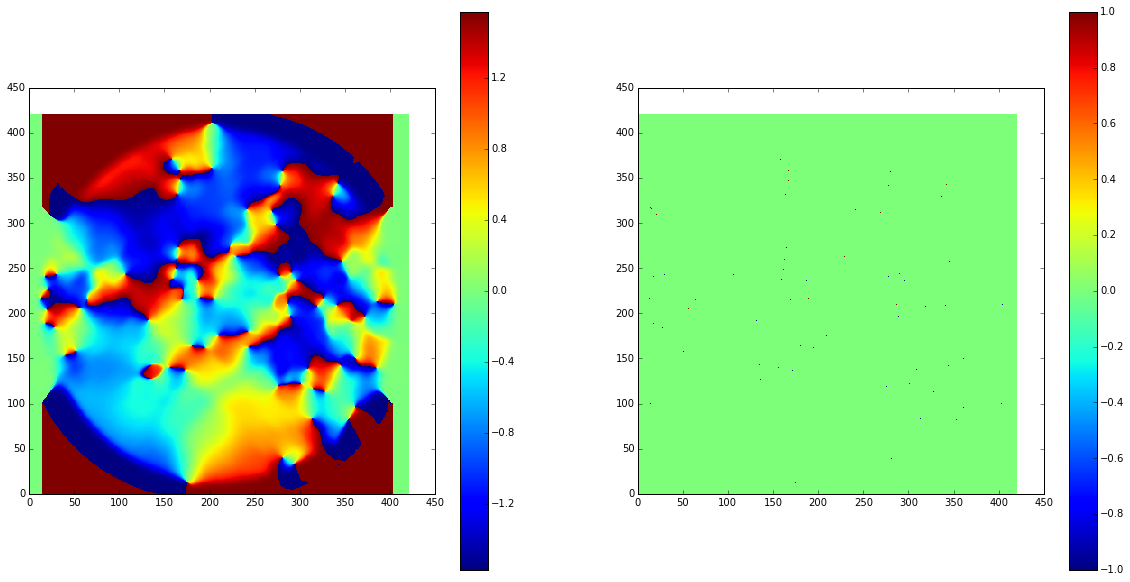

In [16]:
with Timer("Compute Gradient"):
    du = np.gradient(u)
    
with Timer("Compute Orientation Field"):
    OF = OrientationField(du)
    
with Timer("Compute Singular Points"):
    SP = SingularPoints(OF)
    
Plot([OF, SP])

## Singular Point calculation

To compute singular points we think about changes in the direction field as we walk in tight loops. By a tight loop, we mean a walk between four adjacent cells in a 2x2 pattern. As we move from (1,1) to (-1,1) to (-1,-1) to (-1,1) back to (1,1) we observe differences in the direction field. Since the direction field is measured as an angle between $-\pi/2$ and $\pi/2$, there can be larger differences due to jumping over the discontinuity; we can detect and eliminate these discontinuities from our calculations. The sum of the differences in the tight loop then gives us an integer multiple of $\pi$. The algorithm `SingularPoints` above computes the sums of these differences over loops by first "pre-treating" discontinuities in x and y directions and then combining differences. Notice that the resulting answer is an array which is smaller by 1 pixel in each direction. We can interpret this as meaning the singular points are located on lattice points between the data of $u$. If we are satisified with rounding down to the nearest data pixel, this is not a concern.

### Locating Singular Points

In [26]:
locations = [ (i,j,SP[i,j]) for (i,j) in np.argwhere(SP)]
print(locations)

[(12, 175, 1.0), (33, 294, 1.0), (39, 281, -1.0), (82, 353, 1.0), (83, 313, -1.0), (96, 361, -1.0), (100, 14, -1.0), (100, 403, 1.0), (113, 328, -1.0), (116, 314, 1.0), (119, 276, -1.0), (122, 301, 1.0), (127, 136, -1.0), (137, 172, -1.0), (138, 309, -1.0), (139, 385, -1.0), (140, 156, 1.0), (142, 345, 1.0), (143, 135, 1.0), (150, 361, 1.0), (153, 39, 1.0), (158, 51, -1.0), (162, 195, 1.0), (162, 243, 1.0), (164, 180, -1.0), (175, 209, -1.0), (180, 243, 1.0), (184, 27, -1.0), (189, 17, 1.0), (192, 132, -1.0), (196, 372, 1.0), (197, 289, -1.0), (204, 19, -1.0), (205, 56, 1.0), (208, 319, -1.0), (209, 341, -1.0), (210, 287, 1.0), (210, 404, -1.0), (213, 385, 1.0), (215, 64, 1.0), (215, 169, 1.0), (216, 204, -1.0), (216, 326, 1.0), (217, 13, 1.0), (217, 189, 1.0), (227, 20, -1.0), (236, 187, -1.0), (236, 296, -1.0), (238, 159, -1.0), (241, 17, 1.0), (241, 278, -1.0), (243, 30, -1.0), (243, 106, -1.0), (244, 290, 1.0), (249, 162, 1.0), (258, 346, -1.0), (260, 163, 1.0), (263, 229, 1.0), (2

# Analysis of Egolf, Melnikov, and Bodenschatz (EMB Algorithm)

Egolf, David A., Ilarion V. Melnikov, and Eberhard Bodenschatz. "A new fast method for determining local properties of striped patterns." arXiv preprint comp-gas/9702001 (1997).


In [10]:
def EMB_Wavenumber(u, method="difference"):
    u = scipy.ndimage.filters.gaussian_filter(u, sigma=5)
    u = u - np.sum(u)/np.size(u)
    u = u / np.max(np.absolute(u))
    if method == "difference":
        [ux, uy] = np.gradient(u)
        [uxx, uxy] = np.gradient(ux)
        [uxy, uyy] = np.gradient(uy)
        uxxx = np.gradient(uxx)[0]
        uyyy = np.gradient(uyy)[1]
    elif method == "fourier":
        [ux, uy] = fourier_diff(u, order=1)
        [uxx, uyy] = fourier_diff(u, order=2)
        [uxxx, uyyy] = fourier_diff(u, order=3)
        uxy = fourier_diff(ux)[1]
    else:
        raise ValueError('EMB_Wavenumber: Unrecognized method "' + method + '"')
    Test1 = np.absolute(u) > np.maximum(np.absolute(ux),np.absolute(uy))
    Test2 = np.absolute(uxx) > np.absolute(uyy)
    Test3 = np.absolute(ux) > np.absolute(uy)
    Case1 = np.logical_and(Test1, Test2)
    Case2 = np.logical_and(Test1, np.logical_not(Test2))
    Case3 = np.logical_and(np.logical_not(Test1), Test3)
    Case4 = np.logical_and(np.logical_not(Test1), np.logical_not(Test3))
    Case1kx = np.nan_to_num(np.sqrt(np.absolute(uxx / u)))
    Case1ky = Case1kx * np.nan_to_num(uxy / uxx )
    Case2ky = np.nan_to_num(np.sqrt(np.absolute(uyy / u )))
    Case2kx = Case2ky * np.nan_to_num(uxy / uyy)
    Case3kx = np.nan_to_num(np.sqrt(np.absolute(uxxx / ux)))
    Case3ky = Case3kx * np.nan_to_num(uy / ux )
    Case4ky = np.nan_to_num(np.sqrt(np.absolute(uyyy / uy)))
    Case4kx = Case4ky * np.nan_to_num(ux / uy)
    kx = Case1 * Case1kx + Case2 * Case2kx + Case3 * Case3kx + Case4 * Case4kx
    ky = Case1 * Case1ky + Case2 * Case2ky + Case3 * Case3ky + Case4 * Case4ky
    Sign = 1.0 - 2.0 * (kx < 0)
    kx = kx * Sign
    ky = ky * Sign
    return [kx, ky]

In [19]:
with Timer("EMB Wavenumber calculation (difference)"):
    [kx_diff, ky_diff] = EMB_Wavenumber(u, method="difference")

with Timer("EMB Wavenumber calculation (fourier)"):
    [kx_fourier, ky_fourier] = EMB_Wavenumber(u, method="fourier")
    
LWN = scipy.ndimage.filters.gaussian_filter(np.sqrt(kx_fourier**2.0 + ky_fourier**2.0), sigma=4)
    

[EMB Wavenumber calculation (difference)]
Elapsed: 0.0828969478607 seconds
[EMB Wavenumber calculation (fourier)]
Elapsed: 3.49848198891 seconds


/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in divide
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in divide
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in divide
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.

In [21]:
2.0*np.median(LWN)

0.54887897545508335

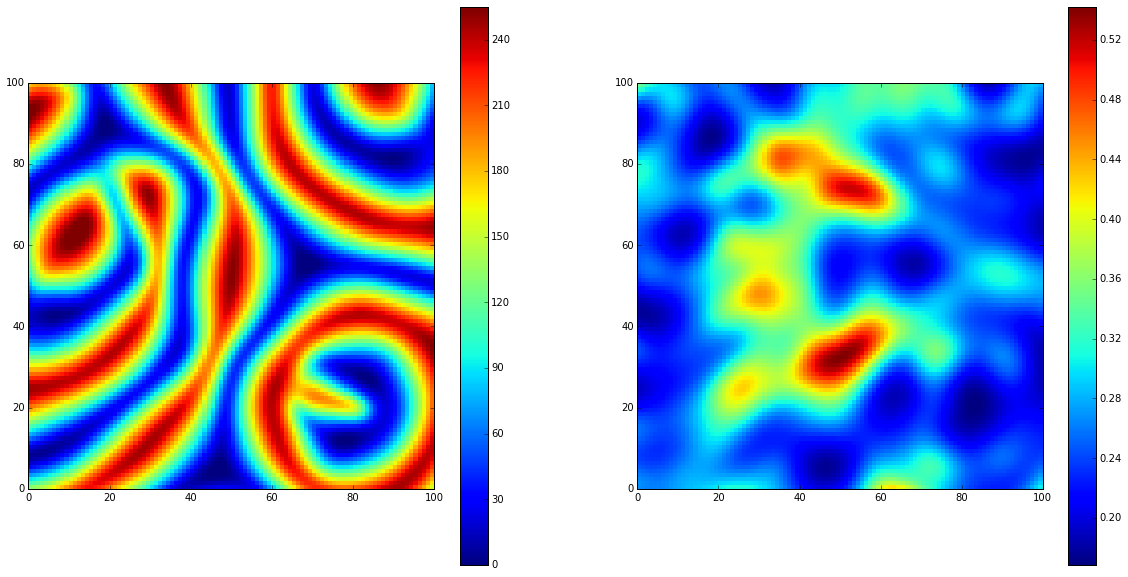

In [20]:
tmp = u[200:300, 200:300]


Plot([tmp, LWN[200:300, 200:300]])

In [29]:
with Timer("Compute Orientation Field"):
    OF_diff = OrientationField([kx_diff, ky_diff])
with Timer("Compute Singular Points"):
    SP_diff = SingularPoints(OF_diff)

[Compute Orientation Field]
Elapsed: 0.0334091186523 seconds
[Compute Singular Points]
Elapsed: 0.0119709968567 seconds


/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in greater


In [30]:
with Timer("Compute Orientation Field"):
    OF_fourier = OrientationField([kx_fourier, ky_fourier])
with Timer("Compute Singular Points"):
    SP_fourier = SingularPoints(OF_fourier)

[Compute Orientation Field]
Elapsed: 0.0419280529022 seconds
[Compute Singular Points]
Elapsed: 0.00674200057983 seconds


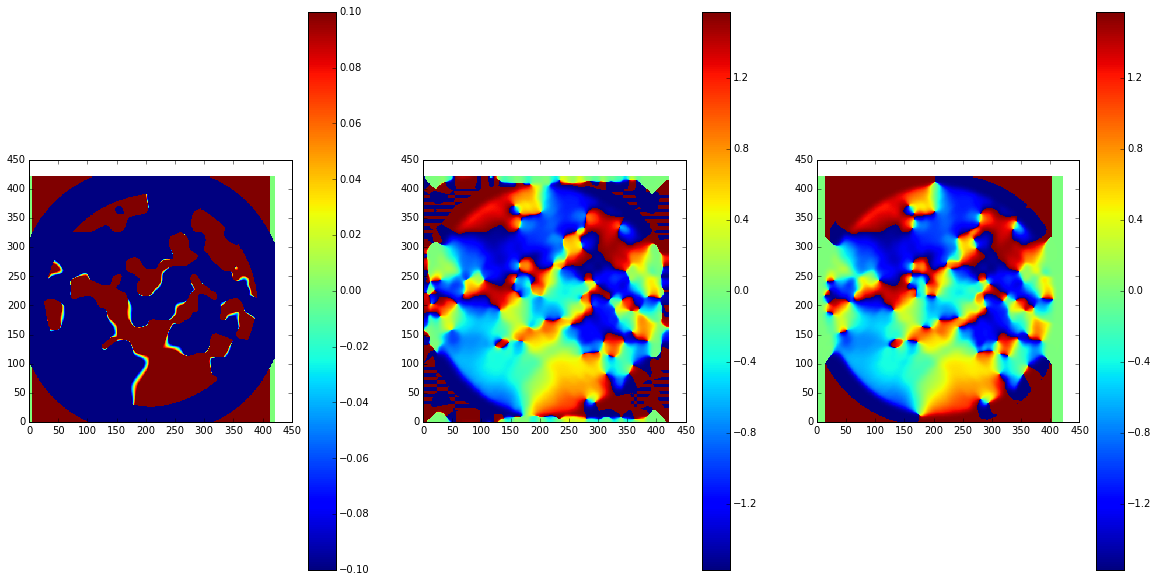

In [31]:
Plot([OF_diff, OF_fourier, OF])

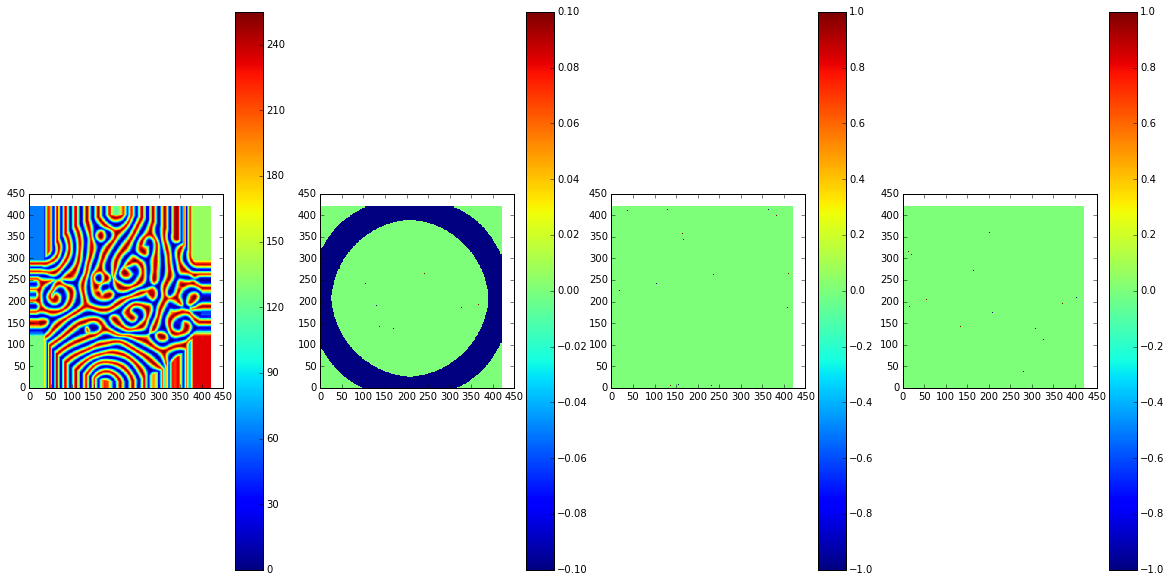

In [32]:
Plot([u, SP_diff, SP_fourier, SP])